# Imports

In [1]:
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

In [2]:
sys.path.insert(1, '/kaggle/input/mpgggg')
from util import *

In [3]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Dataset

In [4]:
data = pd.read_csv('/kaggle/input/mpgggg/auto-mpg.csv')
data.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [5]:
target_col_name = 'mpg'

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    object 
 4   weight        398 non-null    int64  
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car name      398 non-null    object 
dtypes: float64(3), int64(4), object(2)
memory usage: 28.1+ KB


In [7]:
missing_val = data.isin(['?', '', 'None', 'NaN']).sum()
missing_val

mpg             0
cylinders       0
displacement    0
horsepower      6
weight          0
acceleration    0
model year      0
origin          0
car name        0
dtype: int64

In [8]:
rows_to_drop = data.isin(['?', '', 'None', 'NaN']).any(axis=1)
df_with_missing = data[rows_to_drop]
data.drop(df_with_missing.index, inplace=True)

In [9]:
data.drop(columns=['car name'], inplace=True)
data['horsepower'] = data['horsepower'].astype(int)
data['origin'] = data['origin'].map({1: 'US', 2: 'Asia', 3: 'Europe'})
data['model year'] = (1900 + data['model year'])
today = datetime.today()
this_year = today.year
data["age"] = today.year - data["model year"]
data.drop(["model year"], axis = 1, inplace = True)
data.reset_index(inplace=True, drop=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 392 entries, 0 to 391
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           392 non-null    float64
 1   cylinders     392 non-null    int64  
 2   displacement  392 non-null    float64
 3   horsepower    392 non-null    int64  
 4   weight        392 non-null    int64  
 5   acceleration  392 non-null    float64
 6   origin        392 non-null    object 
 7   age           392 non-null    int64  
dtypes: float64(3), int64(4), object(1)
memory usage: 24.6+ KB


In [10]:
object_cols = data.select_dtypes(include='object').columns.to_list()
for col in object_cols:
    print(f"{col} is{'' if is_consumption(data, col, target_col_name, 0.2) else ' not'} a consumption column")

origin is a consumption column


In [11]:
data['origin'] = data['origin'].map({'US':1, 'Asia':2, 'Europe':3})
data['origin']

0      1
1      1
2      1
3      1
4      1
5      1
6      1
7      1
8      1
9      1
10     1
11     1
12     1
13     1
14     3
15     1
16     1
17     1
18     3
19     2
20     2
21     2
22     2
23     2
24     1
25     1
26     1
27     1
28     1
29     3
30     1
31     3
32     1
33     1
34     1
35     1
36     1
37     1
38     1
39     1
40     1
41     1
42     1
43     1
44     1
45     1
46     1
47     1
48     1
49     2
50     2
51     2
52     3
53     3
54     2
55     1
56     3
57     1
58     2
59     1
60     1
61     1
62     1
63     1
64     1
65     1
66     1
67     1
68     1
69     1
70     3
71     1
72     1
73     1
74     1
75     2
76     2
77     2
78     2
79     1
80     3
81     3
82     1
83     3
84     1
85     1
86     1
87     1
88     1
89     1
90     1
91     1
92     1
93     1
94     1
95     1
96     1
97     1
98     1
99     1
100    1
101    2
102    1
103    1
104    1
105    1
106    1
107    3
108    1
109    3
110    3
1

# PCA

In [12]:
pca = PCA(n_components=1)
pca_result = pca.fit_transform(data.drop(columns=[target_col_name]))
data['PCA'] = pca_result[:, 0]

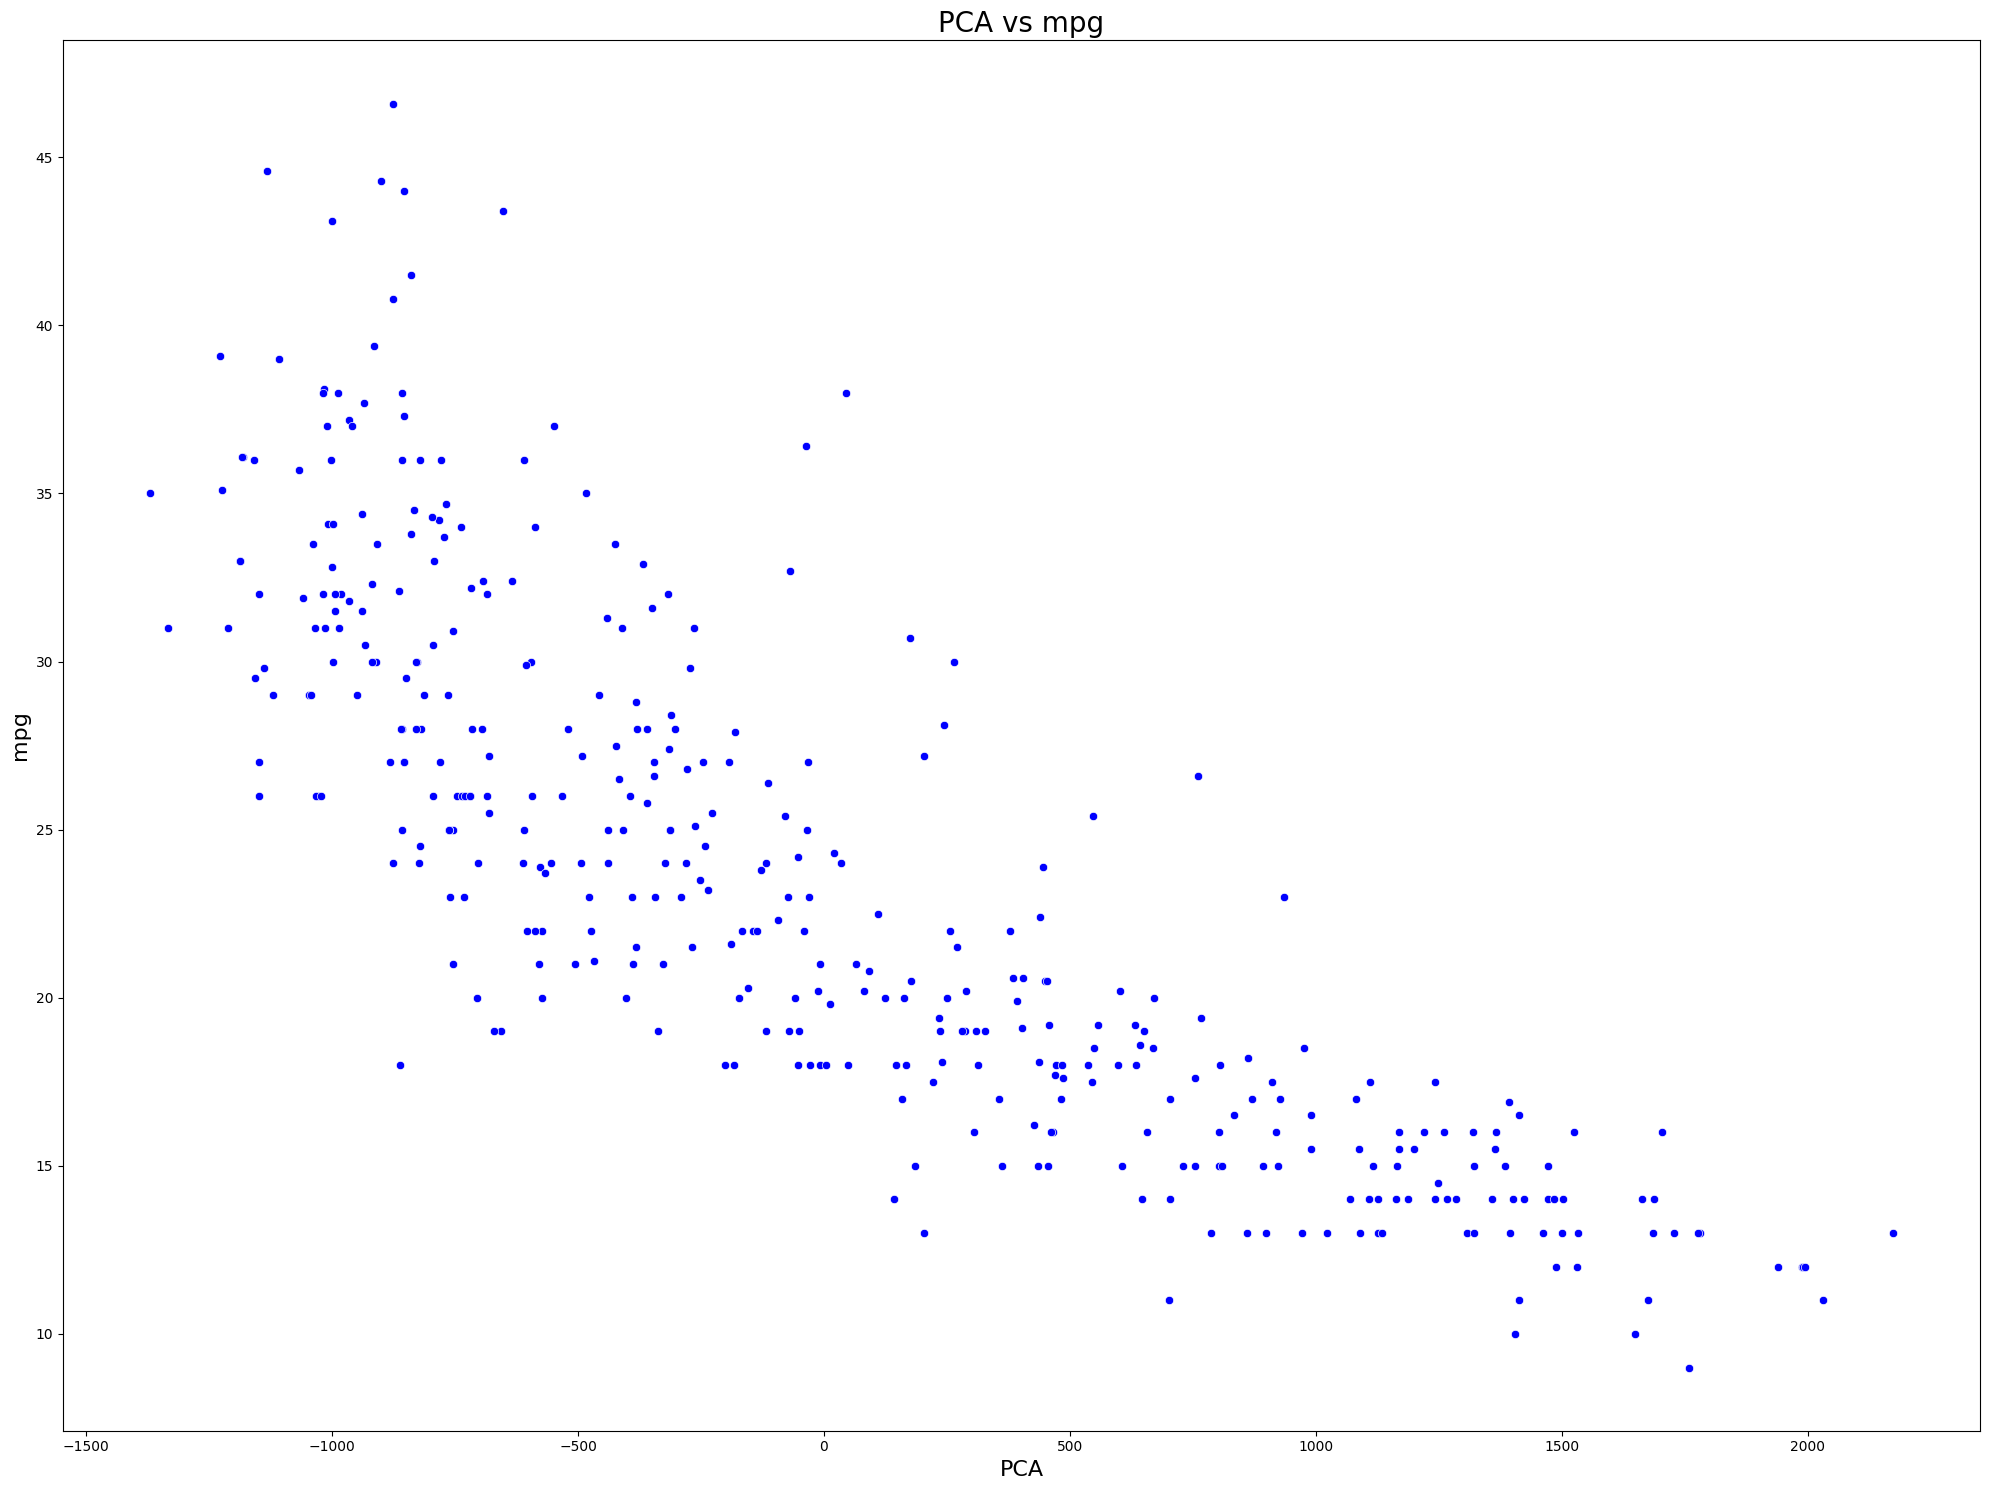

In [13]:
fig, axe = plt.subplots(figsize=(20, 15))

sns.scatterplot(x='PCA', y=target_col_name, data=data, ax=axe, color='b')
axe.set_title(f'PCA vs {target_col_name}', fontsize=20)
axe.set_xlabel('PCA', fontsize=16)
axe.set_ylabel(target_col_name, fontsize=16)

plt.tight_layout()
plt.show()

In [14]:
data['PCA'] = data['PCA'].max() - data['PCA']

# Training

In [15]:
test_pairs = generate_random_pairs(data, 20000)
test_df = create_pair_df(data, test_pairs, target_col_name)

In [16]:
tree_depth = int(np.round(np.sqrt(len(data.columns))))

In [17]:
mf1 = train_evaluate_repeat(generate_random_pairs, data, num_samples=10000, depth=tree_depth, test_df=test_df, use_bradley=True, exp=True, add_noise=False, noise=0.1, label_col=target_col_name, repeats=5)

100%|██████████| 5/5 [01:08<00:00, 13.72s/it]

Mean Accuracy: 0.9447699999999999
Mean Precision: 0.937542480038348
Mean Recall: 0.9502916197687507
Mean F1 Score: 0.9438705638228428


In [18]:
var, residuals = calculate_pca_var(data, target_col_name)
print(var)

1476868.1677587377


In [21]:
# Calculating the number of pairs
max_pairs = len(data) * 100
alpha = 1e-5

num_pairs = int(max_pairs / (1 + alpha * var))
print(num_pairs)

2485


In [22]:
pretrain_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': tree_depth
}
pretrained_model = pretrain_model_with_residuals(df=data, n_samples=num_pairs, pretrain_params=pretrain_params, target_col=target_col_name, residuals=residuals)

In [23]:
step = 50
num_samples = 800
repeats = 40

f1_scores_UB_repeats = []
f1_scores_UP_repeats = []
f1_scores_RB_repeats = []

# Create a for loop from n to num_samples with a step of n
for _ in range(repeats):
    f1_scores_UB, f1_scores_UP, f1_scores_RB = compare_three_methods(
        df=data,
        test_df=test_df,
        pretrain_params=pretrain_params,
        pretrained_model=pretrained_model,
        target_col=target_col_name,
        use_bradley=True,
        exp=False,
        add_noise=False,
        total_pairs=num_samples,
        batch_size=step,
    )
    f1_scores_UB_repeats.append(f1_scores_UB)
    f1_scores_UP_repeats.append(f1_scores_UP)
    f1_scores_RB_repeats.append(f1_scores_RB)

# Compute the average F1 scores across repeats
average_f1_scores_UB = np.mean(f1_scores_UB_repeats, axis=0)
average_f1_scores_UP = np.mean(f1_scores_UP_repeats, axis=0)
average_f1_scores_RB = np.mean(f1_scores_RB_repeats, axis=0)

Blank model with random pairs: 100%|██████████| 16/16 [00:03<00:00,  4.57it/s]


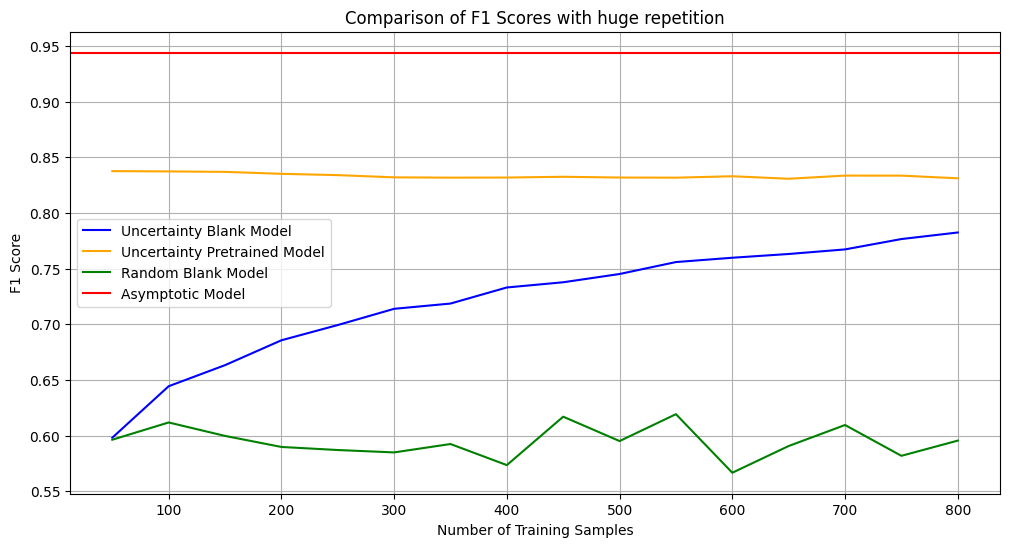

In [24]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(range(step, num_samples+1, step), average_f1_scores_UB, label='Uncertainty Blank Model', color='blue')
plt.plot(range(step, num_samples+1, step), average_f1_scores_UP, label='Uncertainty Pretrained Model', color='orange')
plt.plot(range(step, num_samples+1, step), average_f1_scores_RB, label='Random Blank Model', color='green')
plt.axhline(y = mf1, color = 'r', linestyle = '-', label='Asymptotic Model')
plt.xlabel('Number of Training Samples')
plt.ylabel('F1 Score')
plt.title('Comparison of F1 Scores with huge repetition')
plt.legend()
plt.grid(True)
plt.show()

In [25]:
step = 50
num_samples = 10000
repeats = 1

f1_scores_UB_repeats2 = []
f1_scores_UP_repeats2 = []
f1_scores_RB_repeats2 = []

# Create a for loop from n to num_samples with a step of n
for _ in range(repeats):
    f1_scores_UB, f1_scores_UP, f1_scores_RB = compare_three_methods(
        df=data,
        test_df=test_df,
        pretrain_params=pretrain_params,
        pretrained_model=pretrained_model,
        target_col=target_col_name,
        use_bradley=True,
        exp=False,
        add_noise=False,
        total_pairs=num_samples,
        batch_size=step,
    )
    f1_scores_UB_repeats2.append(f1_scores_UB)
    f1_scores_UP_repeats2.append(f1_scores_UP)
    f1_scores_RB_repeats2.append(f1_scores_RB)

# Compute the average F1 scores across repeats
average_f1_scores_UB2 = np.mean(f1_scores_UB_repeats2, axis=0)
average_f1_scores_UP2 = np.mean(f1_scores_UP_repeats2, axis=0)
average_f1_scores_RB2 = np.mean(f1_scores_RB_repeats2, axis=0)

Blank model with random pairs: 100%|██████████| 200/200 [00:48<00:00,  4.11it/s]


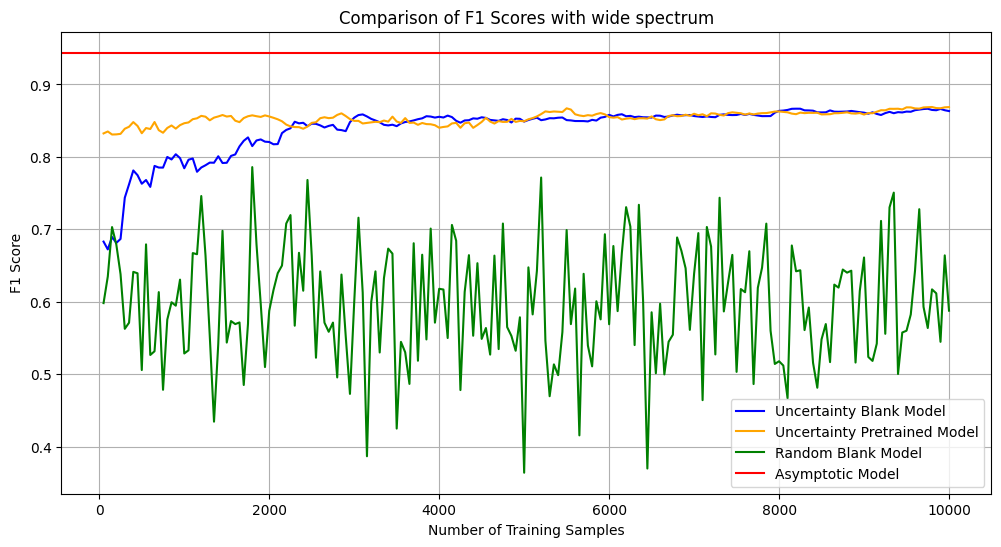

In [26]:
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(range(step, num_samples+1, step), average_f1_scores_UB2, label='Uncertainty Blank Model', color='blue')
plt.plot(range(step, num_samples+1, step), average_f1_scores_UP2, label='Uncertainty Pretrained Model', color='orange')
plt.plot(range(step, num_samples+1, step), average_f1_scores_RB2, label='Random Blank Model', color='green')
plt.axhline(y = mf1, color = 'r', linestyle = '-', label='Asymptotic Model')
plt.xlabel('Number of Training Samples')
plt.ylabel('F1 Score')
plt.title('Comparison of F1 Scores with wide spectrum')
plt.legend()
plt.grid(True)
plt.show()